In [28]:
!pip install -U spacy
!pip install -U torchdata
!pip install datasets
!pip install portalocker
!pip install bertviz
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 80.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: spacy
    Found existing installation: spacy 3.7.2
    Uninstalling spacy-3.7.2:
      Successfully uninstalled spacy-3.7.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 87.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.51
    Uninstalling botocore-1.34.51:
      Successfully uninstalled botocore-1.34.51
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.12.2 requires botocore<1.34.52,>=1.34.41, but you have botocore 1.29.165 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.0 MB/s eta 0:00:00:00:01
  Attempting uninstall: pip
    Found existing installation

In [1]:
import math
from tqdm.notebook import tqdm
from typing import Iterable, List
from timeit import default_timer as timer
import torch
import torch.nn as nn
import pandas as pd
from torch import Tensor
from torch.nn import Transformer
import sentencepiece as spm

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [2]:
use_cuda = torch.cuda.is_available()

# Use this line below to enforce the use of the CPU
#use_cuda = False

DEVICE = torch.device("cuda:0" if use_cuda else "cpu")

print("Available device: {}".format(DEVICE))

Available device: cuda:0


In [3]:
from datasets import load_dataset
train_dataset = load_dataset(
                  "ngxingyu/iwslt17_google_trans_scores_sentiments",
                  # streaming=True,
                  split="train",
                )
test_dataset = load_dataset(
                  "ngxingyu/iwslt17_google_trans_scores_sentiments",
                  # streaming=True,
                  split="test",
                )
validation_dataset = load_dataset(
                    "ngxingyu/iwslt17_google_trans_scores_sentiments",
                    # streaming=True,
                    split="validation",
                )
print(train_dataset[0])
print(test_dataset[0])
print(validation_dataset[0])

Generating train split:   0%|          | 0/229736 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/875 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8549 [00:00<?, ? examples/s]

{'bleurt_score': 0.5358738303184509, 'comet_score': 0.8854652047157288, 'en': "Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.", 'google_zh': '非常感谢你，克里斯。非常荣幸有机会两次登上这个舞台；我非常感激。', 'zh': '非常谢谢，克里斯。的确非常荣幸 能有第二次站在这个台上的机会，我真是非常感激。', 'en_sentiment': [-1.896572470664978, -1.776237964630127, 3.2432024478912354], 'zh_sentiment': [-1.788645625114441, -1.4522335529327393, 2.8387067317962646]}
{'bleurt_score': 0.6811590194702148, 'comet_score': 0.9185108542442322, 'en': 'Several years ago here at TED, Peter Skillman  introduced a design challenge  called the marshmallow challenge.', 'google_zh': '几年前，Peter Skillman 在 TED 上提出了一项名为“棉花糖挑战”的设计挑战。', 'zh': '几年前，在TED大会上， Peter Skillman 介绍了一个设计挑战 叫做“棉花糖挑战”', 'en_sentiment': [-3.196884870529175, 1.5497978925704956, 1.2930272817611694], 'zh_sentiment': [-2.8004977703094482, 2.4916672706604004, -0.260890930891037]}
{'bleurt_score': 0.44820863008499146, 'comet_score': 0.8485136

In [4]:
print(train_dataset, validation_dataset)

Dataset({
    features: ['bleurt_score', 'comet_score', 'en', 'google_zh', 'zh', 'en_sentiment', 'zh_sentiment'],
    num_rows: 229736
}) Dataset({
    features: ['bleurt_score', 'comet_score', 'en', 'google_zh', 'zh', 'en_sentiment', 'zh_sentiment'],
    num_rows: 875
})


In [5]:
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'zh'

# Placeholders
token_transform = {}
vocab_transform = {}

In [6]:
en_data = train_dataset[SRC_LANGUAGE]
zh_data = train_dataset[TGT_LANGUAGE]
data = []
with tqdm(total=len(train_dataset)) as progress_bar:
  for i in range(len(train_dataset)):
      parallel_sentences = {}
      parallel_sentences[SRC_LANGUAGE] = en_data[i]
      parallel_sentences[TGT_LANGUAGE] = zh_data[i]
      data.append(parallel_sentences)
      progress_bar.update(1)

# Concatenate English and Chinese sentences
all_sentences = [entry[SRC_LANGUAGE] for entry in data] + [entry[TGT_LANGUAGE] for entry in data]
# Save the sentences to a text file
with open("all_sentences.txt", "w", encoding="utf-8") as f:
    for sentence in all_sentences:
        f.write(sentence + "\n")

# Define paths for saving models and vocabs
model_prefix = "spm_model"
# Train the SentencePiece model
spm.SentencePieceTrainer.train(input="all_sentences.txt", model_prefix=model_prefix, vocab_size=10000)

  0%|          | 0/229736 [00:00<?, ?it/s]

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: all_sentences.txt
  input_format: 
  model_prefix: spm_model
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0


In [7]:
# Load SentencePiece model
tokeniser = spm.SentencePieceProcessor()
tokeniser.load(f"{model_prefix}.model")

# Test tokeniser
entry = data[0]
english_tokens = tokeniser.encode_as_pieces(entry['en'])
chinese_tokens = tokeniser.encode_as_pieces(entry['zh'])
print("English tokens:", english_tokens)
print("Chinese tokens:", chinese_tokens)

English tokens: ['▁Thank', '▁you', '▁so', '▁much', ',', '▁Chris', '.', '▁And', '▁it', "'", 's', '▁truly', '▁a', '▁great', '▁honor', '▁to', '▁have', '▁the', '▁opportunity', '▁to', '▁come', '▁to', '▁this', '▁stage', '▁twice', ';', '▁I', "'", 'm', '▁extremely', '▁grateful', '.']
Chinese tokens: ['▁', '非常', '谢谢', ',', '克里斯', '。', '的确', '非常', '荣幸', '▁能', '有', '第二', '次', '站在', '这个', '台', '上', '的机会', ',', '我', '真是', '非常', '感', '激', '。']


In [8]:
from torch.utils.data import Dataset
from typing import Iterable, List

class CustomDataset(Dataset):
    def __init__(self, data_iter: Iterable, tokeniser):
        self.data_iter = data_iter
        self.tokeniser = tokeniser
        self.process_data_iter()
        self.tokens = {SRC_LANGUAGE: [], TGT_LANGUAGE: []}

    def __len__(self):
        return len(self.data_iter)

    def __getitem__(self, idx):
        sample = self.data_iter[idx]
        return sample

    def process_data_iter(self):
        en_data = self.data_iter['en']
        zh_data = self.data_iter['zh']
        iter = []
        for i in range(len(self.data_iter)):
          data_sample = {}
          data_sample['en'] = en_data[i]
          data_sample['zh'] = zh_data[i]
          iter.append(data_sample)
        self.data_iter = iter

    def tokenize_sentence(self, sentence: str, language: str):
        tokens = self.tokeniser.encode_as_pieces(sentence)
        self.tokens[language].append(tokens)
        return tokens


    def yield_tokens(self, language: str):
        with tqdm(total=len(self.data_iter)) as progress_bar:
            for data_sample in self.data_iter:
                yield self.tokenize_sentence(data_sample[language], language)
                progress_bar.update(1)

In [9]:
custom_train_dataset = CustomDataset(train_dataset, tokeniser)
custom_validation_dataset = CustomDataset(validation_dataset, tokeniser)
custom_test_dataset = CustomDataset(test_dataset, tokeniser)

# Define special symbols and indices
PAD_IDX, UNK_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<PAD>', '<UNK>', '<SOS>', '<EOS>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(custom_train_dataset.yield_tokens(ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set `UNK_IDX` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

  0%|          | 0/229736 [00:00<?, ?it/s]

  0%|          | 0/229736 [00:00<?, ?it/s]

In [10]:
print('EN vocab length:', len(vocab_transform[SRC_LANGUAGE]))
print('ZH vocab length:', len(vocab_transform[TGT_LANGUAGE]))

EN vocab length: 3881
ZH vocab length: 9611


In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

In [12]:
class RelativePositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(RelativePositionalEncoding, self).__init__()
        self.maxlen = maxlen
        self.embeddings_table = nn.Parameter(torch.Tensor(maxlen * 2 + 1, emb_size))
        nn.init.xavier_uniform_(self.embeddings_table)

    def forward(self, seq_len_q, seq_len_k):
        range_vec_q = torch.arange(seq_len_q)
        range_vec_k = torch.arange(seq_len_k)
        relative_matrix = range_vec_k[None, :] - range_vec_q[:, None]
        clipped_relative_matrix = torch.clamp(relative_matrix, -self.maxlen, self.maxlen)
        relative_position_matrix = clipped_relative_matrix + self.maxlen
        embeddings = self.embeddings_table[relative_position_matrix]


        return embeddings

In [13]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [14]:
''' Adapted from torch.Transformer: https://github.com/pytorch/pytorch/blob/main/torch/nn/modules/transformer.py '''
import copy
from typing import Callable, Optional
from torch.nn import Module, ModuleList
from torch.nn import Linear, Dropout, LayerNorm, MultiheadAttention


def _get_clones(module, N):
    return ModuleList([copy.deepcopy(module) for i in range(N)])


def _get_activation_fn(activation: str) -> Callable[[Tensor], Tensor]:
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu

    raise RuntimeError(f"activation should be relu/gelu, not {activation}")


def _generate_square_subsequent_mask(
        sz: int,
        device: torch.device = torch.device(torch._C._get_default_device()),  # torch.device('cpu'),
        dtype: torch.dtype = torch.get_default_dtype(),
) -> Tensor:
    r"""Generate a square causal mask for the sequence.

    The masked positions are filled with float('-inf'). Unmasked positions are filled with float(0.0).
    """
    return torch.triu(
        torch.full((sz, sz), float('-inf'), dtype=dtype, device=device),
        diagonal=1,
    )

def _detect_is_causal_mask(
        mask: Optional[Tensor],
        is_causal: Optional[bool] = None,
        size: Optional[int] = None,
) -> bool:
    """Return whether the given attention mask is causal.

    Warning:
    If ``is_causal`` is not ``None``, its value will be returned as is.  If a
    user supplies an incorrect ``is_causal`` hint,

    ``is_causal=False`` when the mask is in fact a causal attention.mask
       may lead to reduced performance relative to what would be achievable
       with ``is_causal=True``;
    ``is_causal=True`` when the mask is in fact not a causal attention.mask
       may lead to incorrect and unpredictable execution - in some scenarios,
       a causal mask may be applied based on the hint, in other execution
       scenarios the specified mask may be used.  The choice may not appear
       to be deterministic, in that a number of factors like alignment,
       hardware SKU, etc influence the decision whether to use a mask or
       rely on the hint.
    ``size`` if not None, check whether the mask is a causal mask of the provided size
       Otherwise, checks for any causal mask.
    """
    # Prevent type refinement
    make_causal = (is_causal is True)

    if is_causal is None and mask is not None:
        sz = size if size is not None else mask.size(-2)
        causal_comparison = _generate_square_subsequent_mask(
            sz, device=mask.device, dtype=mask.dtype)

        # Do not use `torch.equal` so we handle batched masks by
        # broadcasting the comparison.
        if mask.size() == causal_comparison.size():
            make_causal = bool((mask == causal_comparison).all())
        else:
            make_causal = False

    return make_causal


def _get_seq_len(
        src: Tensor,
        batch_first: bool
) -> Optional[int]:

    if src.is_nested:
        return None
    else:
        src_size = src.size()
        if len(src_size) == 2:
            # unbatched: S, E
            return src_size[0]
        else:
            # batched: B, S, E if batch_first else S, B, E
            seq_len_pos = 1 if batch_first else 0
            return src_size[seq_len_pos]

class TransformerDecoderLayer(Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super().__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = Linear(d_model, dim_feedforward)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(dim_feedforward, d_model)
        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
        self.norm3 = LayerNorm(d_model)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)
        self.dropout3 = Dropout(dropout)
        self.activation = _get_activation_fn(activation)
    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super().__setstate__(state)
    def forward(self, tgt: Tensor, memory: Tensor, tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None, tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None, tgt_is_causal: Optional[bool] = None,
                memory_is_causal: bool = False) -> Tensor:
        tgt2, self_attn_weights = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask,
                                                  key_padding_mask=tgt_key_padding_mask,
                                                  is_causal=tgt_is_causal)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)

        tgt2, multihead_attn_weights = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask,
                                                            key_padding_mask=memory_key_padding_mask,
                                                            is_causal=memory_is_causal)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)

        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)

        return tgt, (self_attn_weights, multihead_attn_weights)

class TransformerDecoder(Module):
    r"""TransformerDecoder is a stack of N decoder layers.

    Args:
        decoder_layer: an instance of the TransformerDecoderLayer() class (required).
        num_layers: the number of sub-decoder-layers in the decoder (required).
        norm: the layer normalization component (optional).

    Examples::
        >>> decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
        >>> transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
        >>> memory = torch.rand(10, 32, 512)
        >>> tgt = torch.rand(20, 32, 512)
        >>> out = transformer_decoder(tgt, memory)
    """

    __constants__ = ['norm']

    def __init__(self, decoder_layer, num_layers, norm=None):
        super().__init__()
        torch._C._log_api_usage_once(f"torch.nn.modules.{self.__class__.__name__}")
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, tgt: Tensor, memory: Tensor, tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None, tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None, tgt_is_causal: Optional[bool] = None,
                memory_is_causal: bool = False) -> Tensor:
        r"""Pass the inputs (and mask) through the decoder layer in turn.

        Args:
            tgt: the sequence to the decoder (required).
            memory: the sequence from the last layer of the encoder (required).
            tgt_mask: the mask for the tgt sequence (optional).
            memory_mask: the mask for the memory sequence (optional).
            tgt_key_padding_mask: the mask for the tgt keys per batch (optional).
            memory_key_padding_mask: the mask for the memory keys per batch (optional).
            tgt_is_causal: If specified, applies a causal mask as ``tgt mask``.
                Default: ``None``; try to detect a causal mask.
                Warning:
                ``tgt_is_causal`` provides a hint that ``tgt_mask`` is
                the causal mask. Providing incorrect hints can result in
                incorrect execution, including forward and backward
                compatibility.
            memory_is_causal: If specified, applies a causal mask as
                ``memory mask``.
                Default: ``False``.
                Warning:
                ``memory_is_causal`` provides a hint that
                ``memory_mask`` is the causal mask. Providing incorrect
                hints can result in incorrect execution, including
                forward and backward compatibility.

        Shape:
            see the docs in Transformer class.
        """
        output = tgt

        attention_weights = []

        seq_len = _get_seq_len(tgt, self.layers[0].self_attn.batch_first)
        tgt_is_causal = _detect_is_causal_mask(tgt_mask, tgt_is_causal, seq_len)

        for mod in self.layers:
            output, attn_weights = mod(output, memory, tgt_mask=tgt_mask,
                         memory_mask=memory_mask,
                         tgt_key_padding_mask=tgt_key_padding_mask,
                         memory_key_padding_mask=memory_key_padding_mask,
                         tgt_is_causal=tgt_is_causal,
                         memory_is_causal=memory_is_causal)
            attention_weights.append(attn_weights)

        if self.norm is not None:
            output = self.norm(output)

        return output, attention_weights

### Seq2Seq Transformer with Absolute Positional Embeddings


In [15]:
class AbsoluteSeq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(AbsoluteSeq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        decoder_layer = TransformerDecoderLayer(
            emb_size, nhead, dim_feedforward, dropout)
        decoder_norm = LayerNorm(emb_size, eps=1e-5, bias=True)
        self.transformer.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm)

        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):

        decoded, attention = self.transformer.decoder(self.tgt_tok_emb(tgt), memory, tgt_mask)
        return decoded, attention
        # return self.transformer.decoder(self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask)

### Seq2SeqTransformer with Relative Positional Embeddings


In [16]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        decoder_layer = TransformerDecoderLayer(
            emb_size, nhead, dim_feedforward, dropout)
        decoder_norm = LayerNorm(emb_size, eps=1e-5, bias=True)
        self.transformer.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.relative_positional_encoding = RelativePositionalEncoding(emb_size, dropout=dropout)

    def forward(self,
              src: Tensor,
              trg: Tensor,
              src_mask: Tensor,
              tgt_mask: Tensor,
              src_padding_mask: Tensor,
              tgt_padding_mask: Tensor,
              memory_key_padding_mask: Tensor):


        src_positional_encoding = self.relative_positional_encoding(seq_len_q=src.shape[1], seq_len_k=src.shape[1])
        src_padded_tensor = torch.nn.functional.pad(torch.zeros_like(self.src_tok_emb(src)), (0, 0, 0, 0, 0, src_positional_encoding.shape[0] - src.shape[1]))

        tgt_positional_encoding = self.relative_positional_encoding(seq_len_q=trg.shape[1], seq_len_k=trg.shape[1])
        tgt_padded_tensor = torch.nn.functional.pad(torch.zeros_like(self.tgt_tok_emb(trg)), (0, 0, 0, 0, 0, tgt_positional_encoding.shape[0] - trg.shape[1]))

        src_emb = self.src_tok_emb(src) + src_padded_tensor
        tgt_emb = self.tgt_tok_emb(trg) + tgt_padded_tensor

        # Pass embeddings through the transformer
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)


    def encode(self, src: Tensor, src_mask: Tensor):
        src_positional_encoding = self.relative_positional_encoding(seq_len_q=src.shape[1], seq_len_k=src.shape[1])
        src_pad_amounts = [max(0, src.shape[i] - src_positional_encoding.shape[i]) for i in range(len(src.shape))]
        src_padded_tensor = torch.nn.functional.pad(src_positional_encoding, (0, 0, 0, 0, 0, src_pad_amounts[0]))
        encoded = self.transformer.encoder(self.src_tok_emb(src) +  src_padded_tensor, src_mask)
        return encoded

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        tgt_positional_encoding = self.relative_positional_encoding(seq_len_q=tgt.shape[1], seq_len_k=tgt.shape[1])
        tgt_pad_amounts = [max(0, tgt.shape[i] - tgt_positional_encoding.shape[i]) for i in range(len(tgt.shape))]
        tgt_padded_tensor = torch.nn.functional.pad(tgt_positional_encoding, (0, 0, 0, 0, 0, tgt_pad_amounts[0]))
        decoded, attention = self.transformer.decoder(self.tgt_tok_emb(tgt) + tgt_padded_tensor, memory, tgt_mask)

        return decoded, attention

In [17]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask.bool()

def generate_square_subsequent_mask_beam(sz):
    mask = torch.triu(torch.ones(sz, sz, device=DEVICE)).bool().transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [18]:
# Custom transformation function for tokenization using SentencePieceProcessor
def tokenize_with_sentencepiece(tokenizer):
    def transform(txt_input):
        return tokenizer.encode_as_pieces(txt_input)
    return transform

# Helper method to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# method to add SOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([SOS_IDX]), torch.tensor(token_ids), torch.tensor([EOS_IDX])))


# `src` and `tgt` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(tokenize_with_sentencepiece(tokeniser), # Tokenization
                                               vocab_transform[ln], # Vectorization
                                               tensor_transform)    # Add SOS/EOS and create tensor


# Method to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for i in range(len(batch)):
        src_sample, tgt_sample = batch[i][SRC_LANGUAGE], batch[i][TGT_LANGUAGE]
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [19]:
def train_epoch(model, optimizer, criterion):
    model.train()
    losses = 0

    train_dataloader = DataLoader(custom_train_dataset.data_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in tqdm(train_dataloader, total=len(list(train_dataloader))):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        # Remove last entry an all target sequences (typically PAD, can be EOS)
        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        # Remove <SOS> from all targets
        tgt_out = tgt[1:, :]

        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))

def evaluate(model, criterion):
    model.eval()
    losses = 0

    val_dataloader = DataLoader(custom_validation_dataset.data_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in tqdm(val_dataloader, total=len(list(val_dataloader))):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]

        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [20]:
import torch.nn.functional as F

class In_trust_Loss(nn.Module):
    def __init__(self, num_classes, alpha=1, beta=0.8,delta=0.5, ignore_index=PAD_IDX):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes
        self.delta = delta
        self.cross_entropy = torch.nn.CrossEntropyLoss()

    def forward(self, logits,labels):
        ce = self.cross_entropy(logits,labels)
        active_logits = logits.view(-1,self.num_classes)
        active_labels = labels.view(-1)
        pred = F.softmax(active_logits, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        label_one_hot = torch.nn.functional.one_hot(active_labels,self.num_classes).float()
        label_one_hot = torch.clamp(label_one_hot, min=1e-4, max=1.0)
        dce = (-1*torch.sum(pred * torch.log(pred*self.delta + label_one_hot*(1-self.delta)), dim=1))
        # Loss
        loss = self.alpha * ce - self.beta * dce.mean()
        return loss

In [21]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 8
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

# Create model
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)
absolute_transformer = AbsoluteSeq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM) # Uncomment to use for absolute positional encodings

# Initialize weights
for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# Move model to device (ideally GPU, otherwise CPU)
transformer = transformer.to(DEVICE)
absolute_transformer = absolute_transformer.to(DEVICE)

# Definte the custom loss function
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Define optimizer
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Load Existing Model


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load relative model
model_path = '/kaggle/input/final-model/transformer_relational_positional_encoding_model_with_intrust_loss_batch_32_2_epochs_final.pt'
loaded_model_state = torch.load(model_path, map_location=device)
transformer.load_state_dict(loaded_model_state)
transformer.eval()

# Load absolute model
absolute_model_path = '/kaggle/input/spm-unigram-model/transformer_SPM_Unigram_2_epochs.pt'
loaded_model_state = torch.load(absolute_model_path, map_location=device)
absolute_transformer.load_state_dict(loaded_model_state)
absolute_transformer.eval()

AbsoluteSeq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): Multihe

In [23]:
def patch_attention(m):
    forward_orig = m.forward
    def wrap(*args, **kwargs):
        kwargs["need_weights"] = True
        kwargs["average_attn_weights"] = False

        return forward_orig(*args, **kwargs)

    m.forward = wrap

modules = []
class SaveOutput:
    def __init__(self):
        self.outputs = []

    def __call__(self, module, module_in, module_out):
        global modules
        modules.append((module, module_in, module_out))
        self.outputs.append(module_out[1])

    def clear(self):
        self.outputs = []

In [65]:
from bertviz import model_view, head_view
BEAM_SIZE=4
# Method to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    attns = []
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(DEVICE)
        out, attn = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        attns.append(attn)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys, attns

def beam_search_decode(model, src, src_mask, max_len, start_symbol, beam_size=BEAM_SIZE):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)

    # Initialize the beam search candidates with the start symbol
    ys_start = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    beams = [(ys_start, 1, [])]
    for _ in range(max_len - 1):
        new_beams = []

        for ys, score, attns in beams:
            if ys[-1].item() == EOS_IDX:
                # new_beams.append((ys, score))
                continue

            # Generate mask for the target sequence
            tgt_mask = (generate_square_subsequent_mask_beam(ys.size(0)).type(torch.bool)).to(DEVICE)
            # Decode the next token probabilities
            out, attn = model.decode(ys, memory, tgt_mask)
            out = out.transpose(0, 1)
            # Get the probabilities for the next tokens
            prob = F.softmax(model.generator(out[:, -1]), dim=-1)  # Apply softmax to get proper probabilities
            # Get top k candidates and their indices
            topk_probs, topk_indices = torch.topk(prob, beam_size)
            # Expand the current candidates with the topk candidates
            for i in range(beam_size):
                new_score = score * topk_probs[0][i].item()
                next_word = topk_indices[0][i].item()
                new_attn = attns + [attn]
                new_candidate = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
                # new_candidate = ys.append(ys_next)
                new_beams.append((new_candidate, new_score, new_attn))

        # Sort the new beams based on their scores
        new_beams.sort(key=lambda x: x[1], reverse=True)

        # Keep only the top k beams
        if len(new_beams) != 0:
          beams = new_beams[:beam_size]
        # Best beam
    best, best_attn = beams[0][0], beams[0][2]

    return best, best_attn

def beam_search_decode_ngram_blocking(model, src, src_mask, max_len, start_symbol, beam_size=BEAM_SIZE, ngram_size=1, ngram_blocking_window=5):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)

    # Initialize the beam search candidates with the start symbol
    ys_start = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    beams = [(ys_start, 1, [])]
    for _ in range(max_len - 1):
        new_beams = []

        for ys, score, attns in beams:
            if ys[-1].item() == EOS_IDX:
                continue

            # Generate mask for the target sequence
            tgt_mask = (generate_square_subsequent_mask_beam(ys.size(0)).type(torch.bool)).to(DEVICE)
            # Decode the next token probabilities
            out, attn = model.decode(ys, memory, tgt_mask)
            out = out.transpose(0, 1)
            # Get the probabilities for the next tokens
            prob = F.softmax(model.generator(out[:, -1]), dim=-1)  # Apply softmax to get proper probabilities
            # Get top k candidates and their indices
            topk_probs, topk_indices = torch.topk(prob, beam_size)
            # Expand the current candidates with the topk candidates
            for i in range(beam_size):
                next_word = topk_indices[0][i].item()
                new_score = score * topk_probs[0][i].item()
                new_attn = attns + [attn]
                new_candidate = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
                # Check for n-gram blocking
                if is_ngram_blocked(new_candidate, ngram_size, ngram_blocking_window):
                    continue
                new_beams.append((new_candidate, new_score, new_attn))

        # Sort the new beams based on their scores
        new_beams.sort(key=lambda x: x[1], reverse=True)

        # Keep only the top k beams
        if len(new_beams) != 0:
            beams = new_beams[:beam_size]

    # Best beam
    best, best_attn = beams[0][0], beams[0][2]

    return best, best_attn

def is_ngram_blocked(candidate_seq, ngram_size, ngram_blocking_window):
    # print(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(candidate_seq.cpu().numpy())))
    candidate_seq = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(candidate_seq.cpu().numpy()))
    if len(candidate_seq) < ngram_size + 1:
        return False

    ngrams = [tuple(candidate_seq[i:i+ngram_size]) for i in range(len(candidate_seq) - ngram_size + 1)]
    recent_ngrams = ngrams[-ngram_blocking_window:]
    unique_recent_ngrams = set(recent_ngrams)
    # print("ngrams: ", ngrams)
    # print("recent_ngrams: ", recent_ngrams)
    # print("unique_recent_ngrams: ", unique_recent_ngrams)
    if len(unique_recent_ngrams) < len(recent_ngrams):
        # print('here')
        return True  # N-gram repetition found

    return False

def visualize(model: torch.nn.Module, src_sentence: str, file_path: str):
    model.eval()
    encoder_attentions = SaveOutput()
    # Patch to get the attention map out
    for i in range(len(model.transformer.encoder.layers)):
      patch_attention(model.transformer.encoder.layers[i].self_attn)
      model.transformer.encoder.layers[i].self_attn.register_forward_hook(encoder_attentions)

    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens, attn = greedy_decode(model, src, src_mask, max_len=num_tokens+5, start_symbol=SOS_IDX)
    encoder_attentions = encoder_attentions.outputs

    # save html files of both visualizations
    html_head_view = head_view(encoder_attentions, vocab_transform[SRC_LANGUAGE].lookup_tokens(list(src.cpu().numpy())), html_action='return') # head view takes in attentions, tokens
    with open(file_path + "head_view.html", 'w') as file:
        file.write(html_head_view.data)
    html_model_view = model_view(encoder_attentions, vocab_transform[SRC_LANGUAGE].lookup_tokens(list(src.cpu().numpy())), html_action='return')
    with open(file_path + "model_view.html", 'w') as file:
        file.write(html_model_view.data)



# Actual method to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str, strategy=greedy_decode):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens, attns = strategy(model, src, src_mask, max_len=num_tokens+5, start_symbol=SOS_IDX)
    if not isinstance(tgt_tokens, list):
      tgt_tokens = tgt_tokens.flatten()
      tgt_tokens=list(tgt_tokens.cpu().numpy())

    tgt = vocab_transform[TGT_LANGUAGE].lookup_tokens(tgt_tokens)
    return (
        "".join(tgt).replace("<SOS>", "").replace("<EOS>", "").replace("<PAD>", ""),
        attns, vocab_transform[SRC_LANGUAGE].lookup_tokens(list(src)), tgt[1:]
    )

def translate_dataset(model, validation_dataset):
    translations = []
    for sample in tqdm(validation_dataset, total=len(validation_dataset)):
        src_sentence = sample[SRC_LANGUAGE]
        tgt_sentence = sample[TGT_LANGUAGE]

        # Translate the source sentence using the model
        translated_sentence = translate(model, src_sentence)

        # Append the translation along with source and target sentences
        translations.append({'en': src_sentence, 'zh': tgt_sentence, 'translated_output': translated_sentence})

    return pd.DataFrame(translations)

In [30]:
ALPHA = 0.6  # normalization parameter 0.6-1
BETA = 0.1   # Coverage penalty factor 0.1-1

def calculate_score(log_probs, attn_weights, alpha=ALPHA, beta=BETA):
    print(log_probs)
    len_Y = len(log_probs)
    lpY = ((5 + len_Y)**alpha) / (5 + 1)**alpha  # length normalization

    coverage = attn_weights.sum(0).clamp(max=1.0)  # Summing and limiting the maximum value to 1.0
    cpX_Y = beta * torch.log(coverage).sum()  #  Calculation of coverage penalties

    score = log_probs.sum() / lpY + cpX_Y  # Calculate the score according to the formula

    return score

def beam_search_decode2(model, src, src_mask, max_len, start_symbol, beam_size=2, alpha=ALPHA, beta=BETA):
    device = src.device
    memory = model.encode(src.to(device), src_mask.to(device))
    start_token = torch.tensor([[start_symbol]], device=device)
    beams = [(start_token, 0.0, torch.tensor([], device=device))]  # Initialize beams

    for step in range(max_len):
        new_beams = []
        for ys, score, all_attn_weights in beams:
            if ys[-1, -1] == EOS_IDX:
                new_beams.append((ys, score, all_attn_weights))
                continue

            out, attn_weights = model.decode(ys, memory, tgt_mask=None)
            prob = model.generator(out[:, -1])

            topk_probs, topk_indices = torch.topk(prob, beam_size)
            for i in range(beam_size):
                next_word = topk_indices[:, i:i+1]
                log_prob = torch.log(topk_probs[:, i])

                new_ys = torch.cat([ys, next_word], dim=1)
                new_score = score + log_prob.item()
                new_all_attn_weights = torch.cat([all_attn_weights, attn_weights], dim=0) if all_attn_weights.size(0) > 0 else attn_weights

                new_beams.append((new_ys, new_score, new_all_attn_weights))

        # Sort by score and keep the first beam_size beams
        beams = sorted(new_beams, key=lambda x: calculate_score(x[1], x[2], alpha, beta), reverse=True)[:beam_size]

    # Select the beam with the highest score
    best_beam = max(beams, key=lambda x: calculate_score(x[1], x[2], alpha, beta))
    return best_beam[0][0], best_beam[0][2]  # Return the best sequence

In [31]:
# get font with chinese characters
!wget https://github.com/google/fonts/raw/main/ofl/notosanssc/NotoSansSC%5Bwght%5D.ttf
!mv NotoSansSC[wght].ttf /usr/share/fonts/

--2024-04-17 11:11:40--  https://github.com/google/fonts/raw/main/ofl/notosanssc/NotoSansSC%5Bwght%5D.ttf
Resolving github.com (github.com)... 20.248.137.48
Connecting to github.com (github.com)|20.248.137.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google/fonts/main/ofl/notosanssc/NotoSansSC%5Bwght%5D.ttf [following]
--2024-04-17 11:11:40--  https://raw.githubusercontent.com/google/fonts/main/ofl/notosanssc/NotoSansSC%5Bwght%5D.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17772300 (17M) [application/octet-stream]
Saving to: 'NotoSansSC[wght].ttf'

NotoSansSC[wght].tt 100%[===================>]  16.95M  --.-KB/s    in 0.07s   

2024-04-17 11:11:42 (230 MB/s) - 'NotoSansSC[wght].tt

**Attention HeatMaps for Normal Beam Search (Short Sentences)**

But we need more.


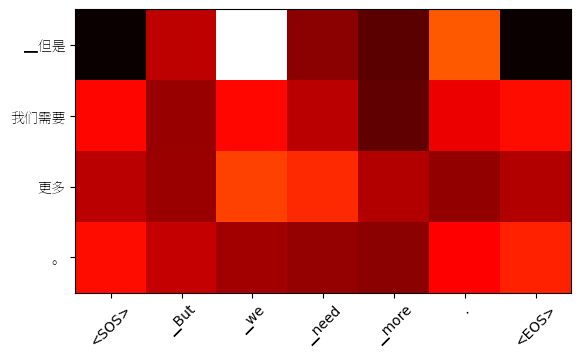

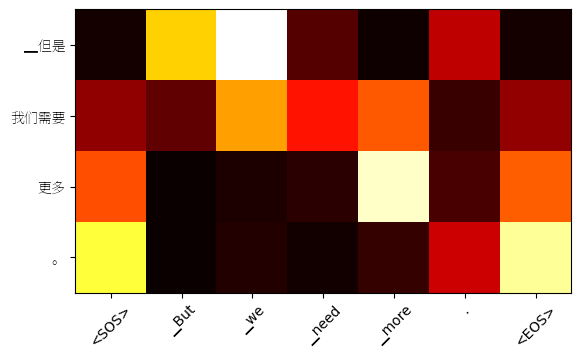

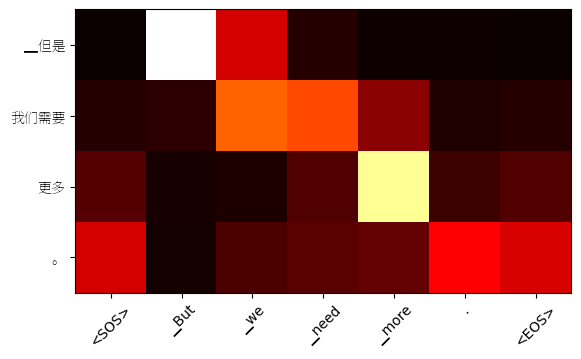

And it was a huge success


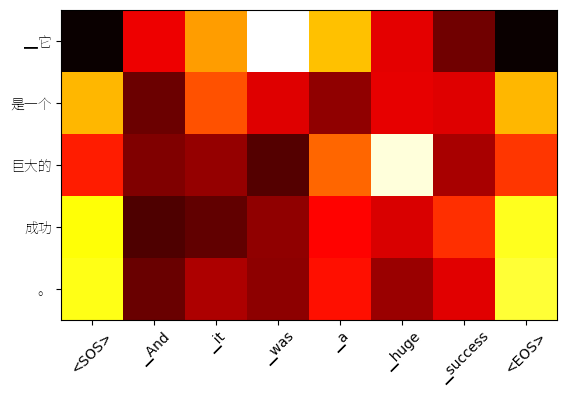

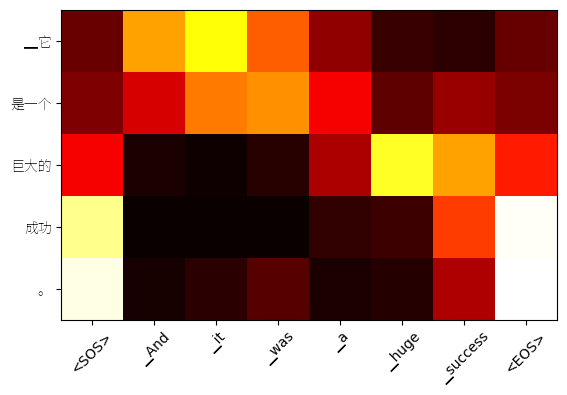

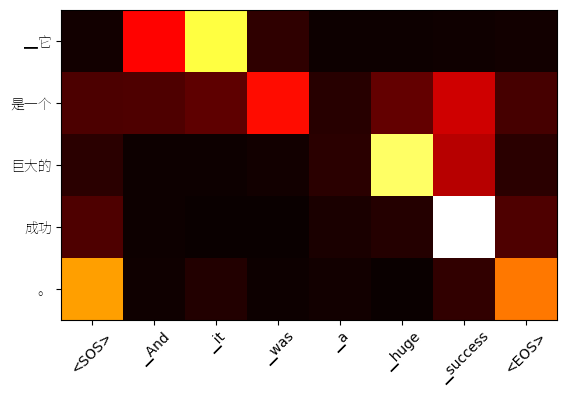

I don't know.


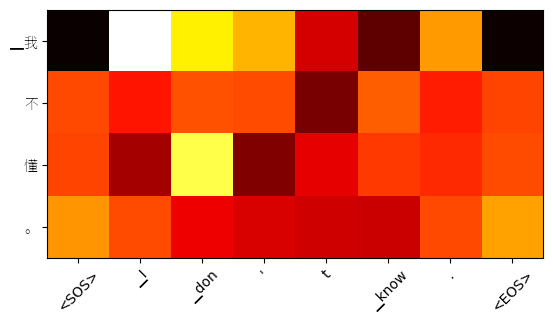

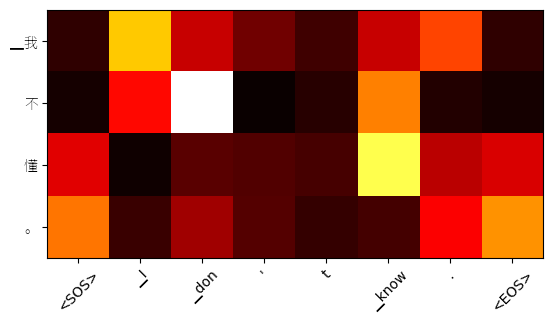

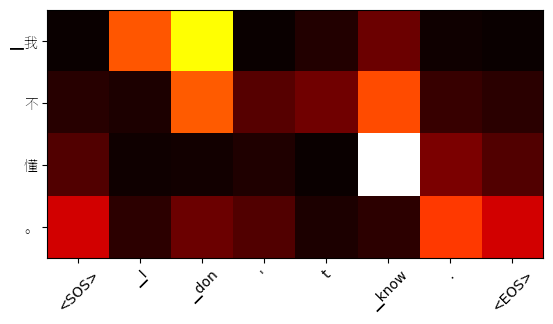

Thanks.


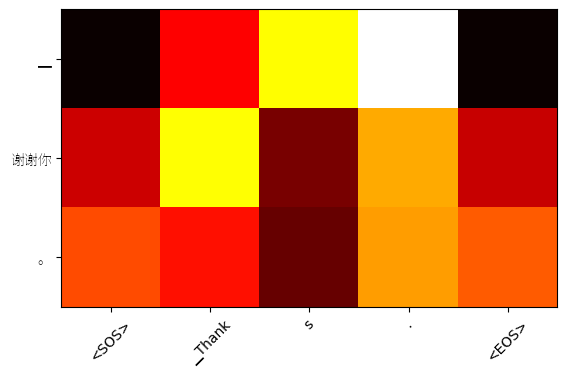

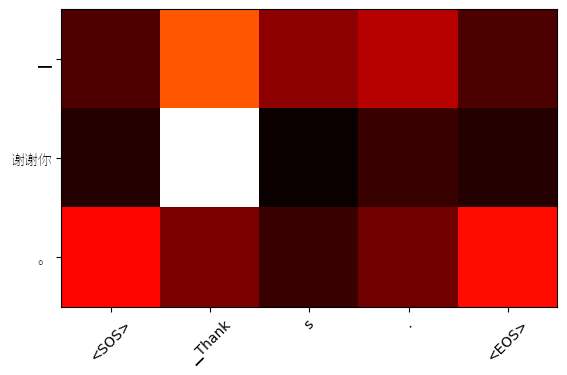

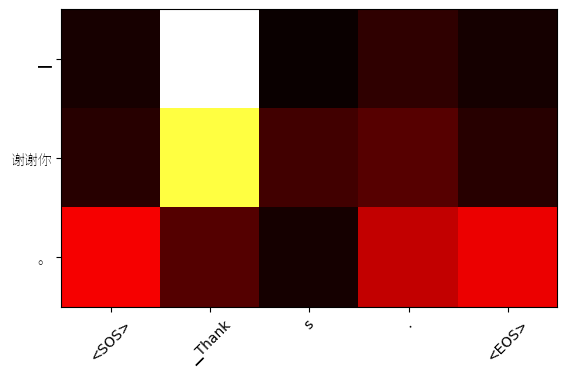

In [68]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
from pathlib import Path

for sentence in [
    "But we need more.",
    "And it was a huge success",
    "I don't know.",
    "Thanks."
]:
  print(sentence)
  output, attns, src, tgt = translate(
      transformer,
      sentence,
      beam_search_decode
      # greedy_decode
    )
  fpath = Path("/usr/share/fonts/NotoSansSC[wght].ttf")
  rows_to_omit = [i for i, token in enumerate(tgt) if token == '<PAD>']

  for i in range(3):
    iteration = i + 1
    # Filter out the rows to omit
    data = attns[-1][i][1][0]
    filtered_tensor_data = data[[j for j in range(data.shape[0]) if j not in rows_to_omit]]

    # Convert the filtered tensor to a NumPy array
    data_to_plot = filtered_tensor_data.detach().cpu().numpy()
    save_images_link = "/kaggle/working/transformer_relational_positional_encoding_model_with_ce_loss_2_epochs_batch_32_head_{}.png".format(iteration)
    plt.imshow(data_to_plot, cmap="hot")
    plt.yticks(ticks=range(len(tgt)), labels=tgt, font=fpath, )
    plt.xticks(ticks=range(len(src)), labels=src, rotation=45)
    plt.imshow((data_to_plot), cmap='hot', interpolation='nearest')
    plt.savefig(save_images_link)
    plt.show()
    plt.close()


**Attention HeatMaps for Normal Beam Search (Longer Sentences)**

Dosage has something to do with this.


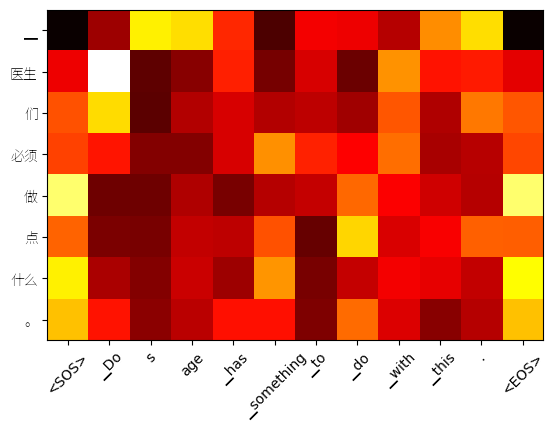

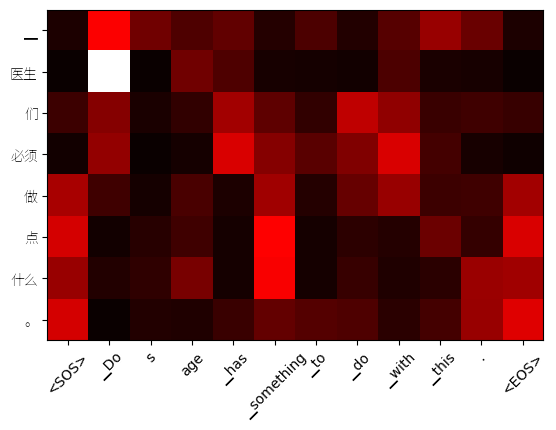

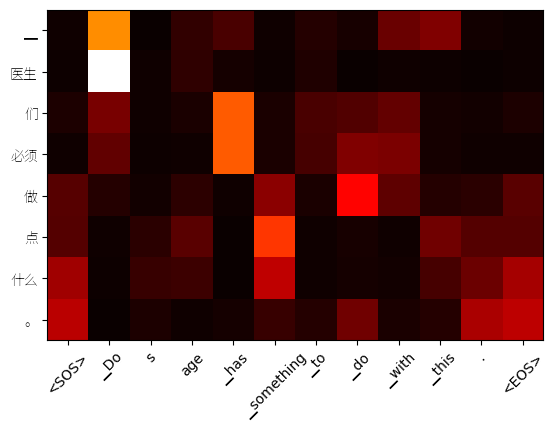

Dwarves became columns.


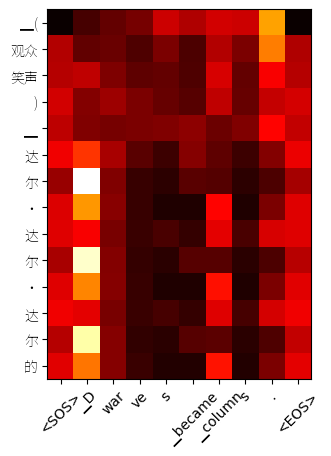

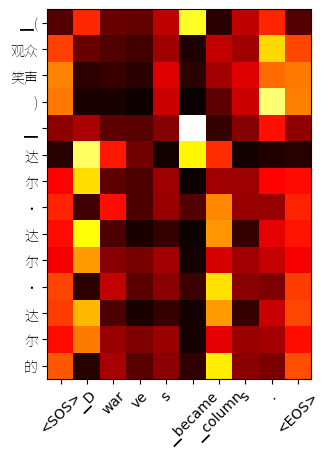

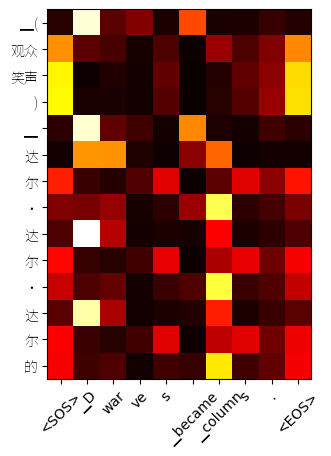

In [69]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
from pathlib import Path

for sentence in [
    "Dosage has something to do with this.",
    "Dwarves became columns.",
]:
  print(sentence)
  output, attns, src, tgt = translate(
      transformer,
      sentence,
      beam_search_decode
      # greedy_decode
    )
  fpath = Path("/usr/share/fonts/NotoSansSC[wght].ttf")
  rows_to_omit = [i for i, token in enumerate(tgt) if token == '<PAD>']

  for i in range(3):
    iteration = i + 1
    # Filter out the rows to omit
    data = attns[-1][i][1][0]
    filtered_tensor_data = data[[j for j in range(data.shape[0]) if j not in rows_to_omit]]

    # Convert the filtered tensor to a NumPy array
    data_to_plot = filtered_tensor_data.detach().cpu().numpy()
    save_images_link = "/kaggle/working/transformer_relational_positional_encoding_model_with_ce_loss_2_epochs_batch_32_head_{}.png".format(iteration)
    plt.imshow(data_to_plot, cmap="hot")
    plt.yticks(ticks=range(len(tgt)), labels=tgt, font=fpath, )
    plt.xticks(ticks=range(len(src)), labels=src, rotation=45)
    plt.imshow((data_to_plot), cmap='hot', interpolation='nearest')
    plt.savefig(save_images_link)
    plt.show()
    plt.close()


**Attention HeatMaps for Beam Search With Ngram Blocking (Longer Sentences)**


But we need more.


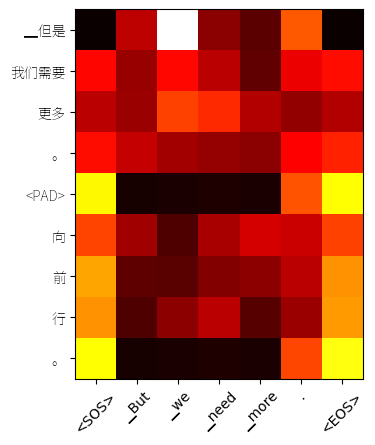

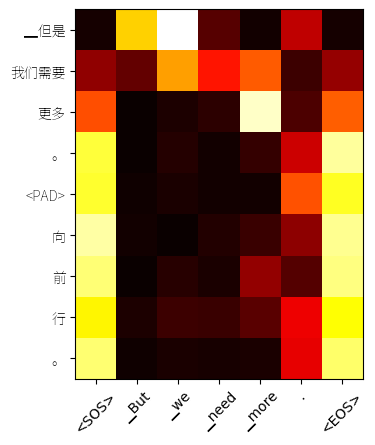

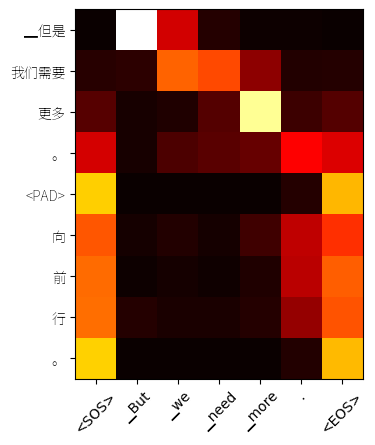

And it was a huge success


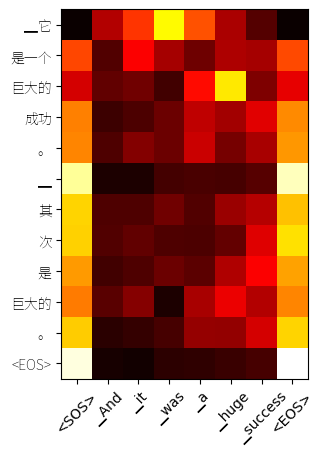

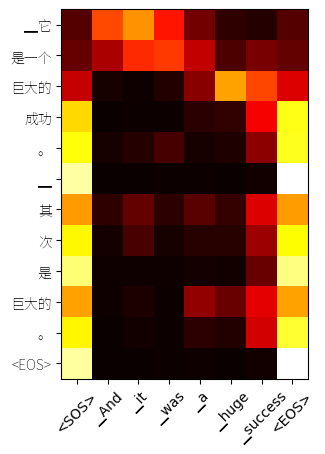

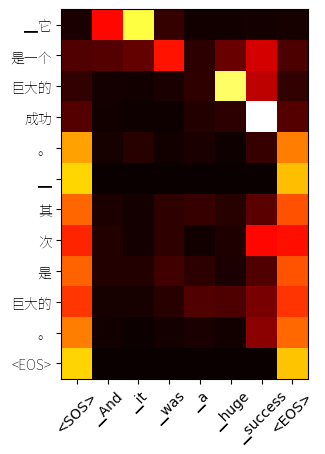

I don't know.


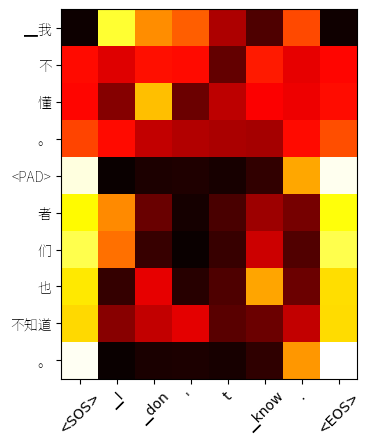

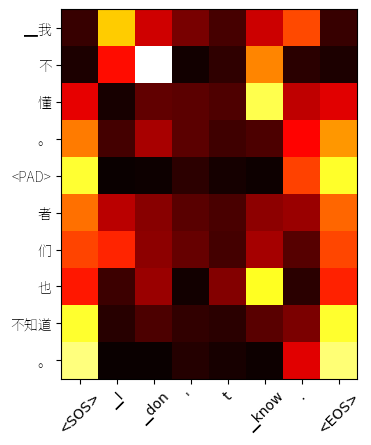

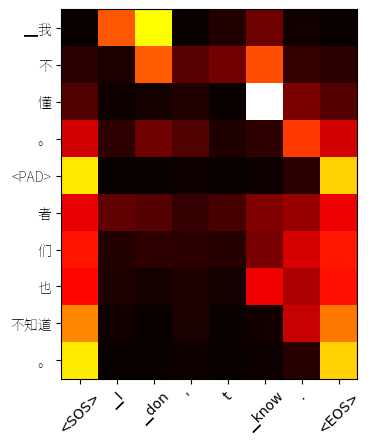

Thanks.


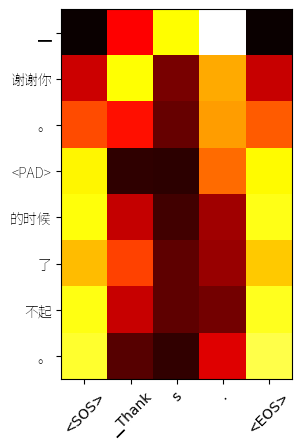

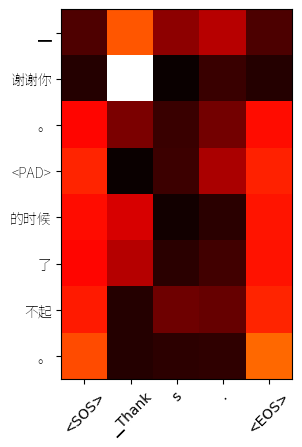

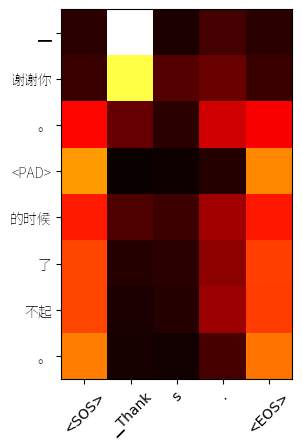

In [70]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
from pathlib import Path

for sentence in [
    "But we need more.",
    "And it was a huge success",
    "I don't know.",
    "Thanks."
]:
  print(sentence)
  output, attns, src, tgt = translate(
      transformer,
      sentence,
      beam_search_decode_ngram_blocking
      # greedy_decode
    )
  fpath = Path("/usr/share/fonts/NotoSansSC[wght].ttf")
  rows_to_omit = [i for i, token in enumerate(tgt) if token == '<PAD>']

  for i in range(3):
    iteration = i + 1
    # Filter out the rows to omit
    data = attns[-1][i][1][0]
    filtered_tensor_data = data[[j for j in range(data.shape[0]) if j not in rows_to_omit]]

    # Convert the filtered tensor to a NumPy array
    data_to_plot = filtered_tensor_data.detach().cpu().numpy()
    save_images_link = "/kaggle/working/transformer_relational_positional_encoding_model_with_ce_loss_2_epochs_batch_32_head_{}.png".format(iteration)
    plt.imshow(data_to_plot, cmap="hot")
    plt.yticks(ticks=range(len(tgt)), labels=tgt, font=fpath, )
    plt.xticks(ticks=range(len(src)), labels=src, rotation=45)
    plt.imshow((data_to_plot), cmap='hot', interpolation='nearest')
    plt.savefig(save_images_link)
    plt.show()
    plt.close()

**Attention HeatMaps for Beam Search with Ngram Blocking (Longer Sentences)**

Dosage has something to do with this.


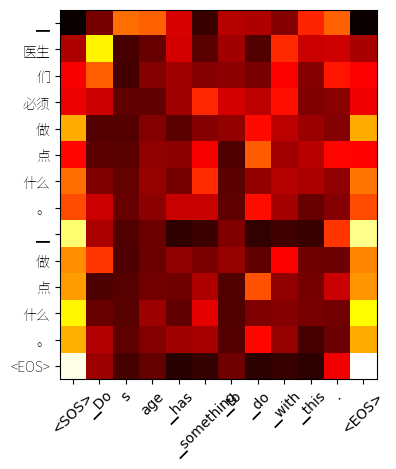

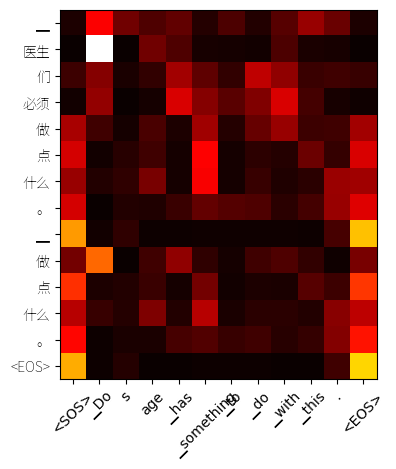

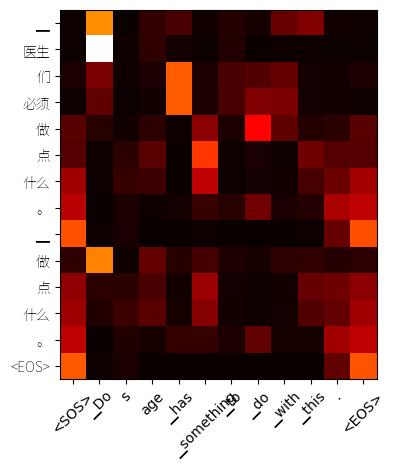

Dwarves became columns.


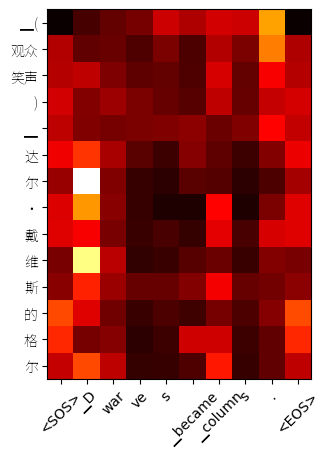

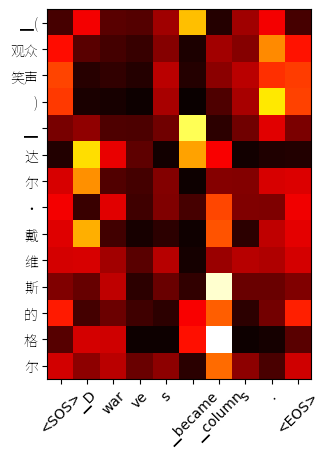

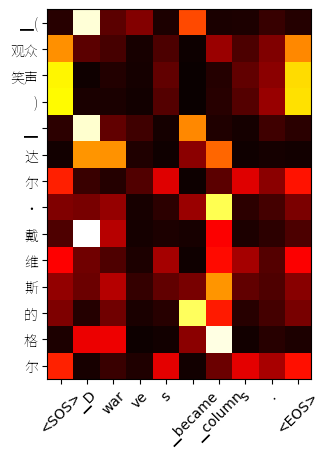

In [71]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
from pathlib import Path

for sentence in [
    "Dosage has something to do with this.",
    "Dwarves became columns.",
]:
  print(sentence)
  output, attns, src, tgt = translate(
      transformer,
      sentence,
      beam_search_decode_ngram_blocking
      # greedy_decode
    )
  fpath = Path("/usr/share/fonts/NotoSansSC[wght].ttf")
  rows_to_omit = [i for i, token in enumerate(tgt) if token == '<PAD>']

  for i in range(3):
    iteration = i + 1
    # Filter out the rows to omit
    data = attns[-1][i][1][0]
    filtered_tensor_data = data[[j for j in range(data.shape[0]) if j not in rows_to_omit]]

    # Convert the filtered tensor to a NumPy array
    data_to_plot = filtered_tensor_data.detach().cpu().numpy()
    save_images_link = "/kaggle/working/transformer_relational_positional_encoding_model_with_ce_loss_2_epochs_batch_32_head_{}.png".format(iteration)
    plt.imshow(data_to_plot, cmap="hot")
    plt.yticks(ticks=range(len(tgt)), labels=tgt, font=fpath, )
    plt.xticks(ticks=range(len(src)), labels=src, rotation=45)
    plt.imshow((data_to_plot), cmap='hot', interpolation='nearest')
    plt.savefig(save_images_link)
    plt.show()
    plt.close()